# Применение алгоритмов кластеризации для диагностики кризиса теплообмена в ЯЭУ
Группа: ИВТ-М20.<br/>
Студент: Лискунов Роман Геннадьвич

In [166]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import (
    DataFrame,
    read_csv,
    Series
)
from sklearn.cluster import (
    AgglomerativeClustering,
    KMeans,
    SpectralBiclustering
)
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_completeness_v_measure
import matplotlib as mpl

In [167]:
mpl.style.use(['ggplot'])

## Чтение данных из файлов (1)

In [168]:
target = DataFrame(read_csv('data/target5.csv', header=0))
target.columns = ['index']
var = DataFrame(read_csv('data/var5.csv', sep=',', header=None))


## Транспонирование исходной матрицы (2)

In [169]:
targetT = target.T
varT = var.T

## Отображение нескольких первых и последних записей (3)

In [170]:
print(target.head())
print(target.tail())

print(varT.head())
print(varT.tail())

   index
0      1
1      1
2      1
3      1
4      1
    index
25      2
26      2
27      2
28      2
29      2
          0          1          2          3          4          5   \
0  10.659607   5.623670   5.773385   8.318744  10.798757   3.392248   
1  12.707813  12.437502  12.293281  15.946799  15.800968  18.957569   
2   4.944295   7.421738   7.322419  11.696521   8.865894  15.108460   
3  12.466091   6.826808   8.880880   7.573538  13.083592   9.473492   
4   6.401173   6.063046   6.493885   6.441410   7.014855   7.835656   

          6          7          8          9   ...         20         21  \
0   9.309021   9.674849   7.147078   5.687350  ...   3.767338   3.364593   
1  13.885331  16.345535  16.292809  14.086400  ...  11.893540  11.259945   
2   8.064355  11.124848  12.013884  11.838692  ...   9.419042   7.984121   
3   9.935888  11.891872   9.359934   2.525389  ...   4.556077   6.467037   
4   6.399653   7.208384   7.036673   5.654433  ...   4.422181   6.124507   

  

## Графики временных реализаций каждого спектра (4)


<Figure size 432x288 with 0 Axes>

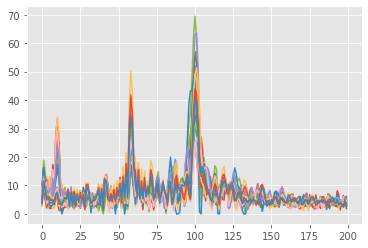

In [171]:
plt.figure()
varT.plot(legend=False);

## График временной реализации для двух случайных спектров (5)

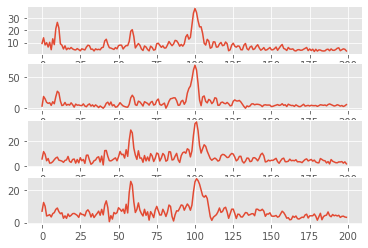

In [172]:
fig, axes = plt.subplots(nrows=4, ncols=1)

varT[6].plot(ax=axes[0])
varT[5].plot(ax=axes[1])
varT[17].plot(ax=axes[2])
varT[27].plot(ax=axes[3]);

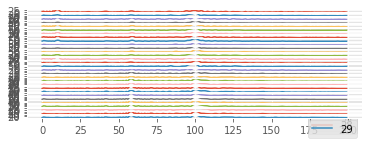

In [173]:
varT.plot(subplots=True, layout=(60,1));

## Мощность каждого спектра (6)

In [174]:
varPower = round(varT.sum(axis = 0), 2)
varPower

0     1467.89
1     1405.75
2     1505.32
3     1600.52
4     1605.70
5     1718.63
6     1534.71
7     1663.00
8     1632.57
9     1523.90
10    1530.40
11    1449.30
12    1430.12
13    1460.62
14    1291.22
15    1502.15
16    1570.58
17    1392.40
18    1345.57
19    1473.14
20    1399.76
21    1596.61
22    1350.12
23    1576.82
24    1471.70
25    1653.05
26    1420.47
27    1321.17
28    1554.44
29    1515.23
dtype: float64

## График распределения целевой переменной target. Фиксация начала кризиса  (7)


crisisLine: 17


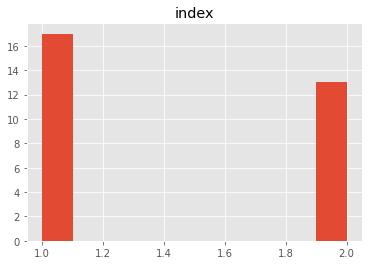

In [175]:
target.hist()
targetTimed = target
targetTimed['time'] = target.index
crisisLine = targetTimed[targetTimed['index']>=2].iloc[0]['time']
print(f'crisisLine: {crisisLine}')

## График мощности спектра с вертикальной линией (8)

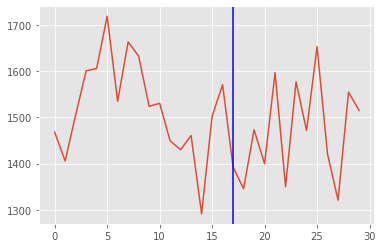

In [176]:
varPlotPower = varPower.plot()
varPlotPower.axvline(x = crisisLine, color='b');

## Описательные статистики мощностей до и после начала кризиса (9)

In [177]:
varPowerBefore = varPower[0:crisisLine]
varPowerAfter = varPower[crisisLine:]
print(varPowerBefore.describe())
print(varPowerAfter.describe())

count      17.000000
mean     1523.081176
std       104.398682
min      1291.220000
25%      1460.620000
50%      1523.900000
75%      1600.520000
max      1718.630000
dtype: float64
count      13.000000
mean     1466.960000
std       106.234579
min      1321.170000
25%      1392.400000
50%      1471.700000
75%      1554.440000
max      1653.050000
dtype: float64


## Средние значения мощности спектра до кризиса и после (10)

In [178]:
print(round(varPowerBefore.mean(), 2))
print(round(varPowerAfter.mean(), 2))

1523.08
1466.96


## Добавление к графику средних значений мощности спектра до кризиса и после (11)

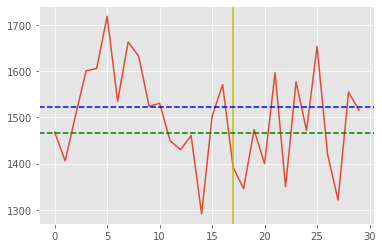

In [179]:
varPlot = varPower.plot()
varPlot.axvline(x = crisisLine, color='y')
varPlot.axhline(y = varPowerAfter.mean(), color='g', linestyle = '--')
varPlot.axhline(y = varPowerBefore.mean(), color='b', linestyle = '--');

## Диаграммы ящиков с усами (boxplots) мощности спектра до кризиса и после (11)

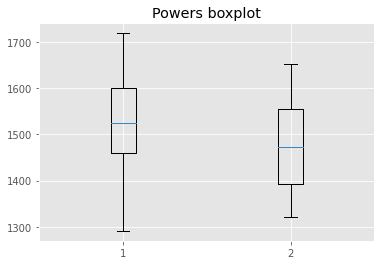

In [180]:
data = [varPowerBefore, varPowerAfter]
fig, ax = plt.subplots()
ax.set_title('Powers boxplot')
ax.boxplot(data);

После кризиса среднее значение мощности существенно уменьшается.

## Средняя частота спектра (12)

In [181]:
print(varT[5])

0       3.392248
1      18.957569
2      15.108460
3       9.473492
4       7.835656
         ...    
195     3.391700
196     4.380358
197     2.753954
198     3.863502
199     5.802209
Name: 5, Length: 200, dtype: float64


In [182]:
def mean_frq(data):
    mfr = []
    for col in data.columns:
        mfr.append((np.arange(1,201) * data[col]).sum() / data[col].sum())
    return Series(mfr)

In [183]:
varPowerFrequency = mean_frq(varT)
print(round(varPowerFrequency, 2))

0     88.27
1     93.77
2     91.94
3     93.08
4     88.77
5     92.99
6     90.82
7     90.28
8     92.32
9     96.95
10    94.82
11    96.04
12    92.39
13    89.57
14    97.02
15    93.85
16    93.03
17    93.81
18    95.99
19    92.15
20    92.86
21    91.72
22    94.72
23    91.50
24    92.00
25    90.20
26    92.58
27    93.02
28    91.87
29    93.83
dtype: float64


## График значений средних частот спектра с вертикальной линией (13)

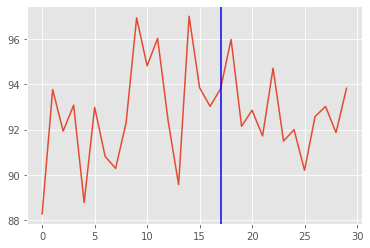

In [184]:
varPlot = varPowerFrequency.plot()
varPlot.axvline(x = crisisLine, color='b')

## Описательные статистики частот до и после начала кризиса (14)

In [185]:
varPowerFreqBefore = varPowerFrequency[0:crisisLine]
varPowerFreqAfter = varPowerFrequency[crisisLine:]
print(varPowerFreqBefore.describe())
print(varPowerFreqAfter.describe())

count    17.000000
mean     92.700084
std       2.623197
min      88.273374
25%      90.818495
50%      92.988608
75%      93.852457
max      97.015090
dtype: float64
count    13.000000
mean     92.787851
std       1.515559
min      90.201003
25%      91.871079
50%      92.579705
75%      93.809026
max      95.987546
dtype: float64


## Средние значения мощности спектра до кризиса и после (15)

In [186]:
print(round(varPowerFreqBefore.mean(), 2))
print(round(varPowerFreqAfter.mean(), 2))

92.7
92.79


## Добавление к графику средних значений частот спектра до кризиса и после (16)

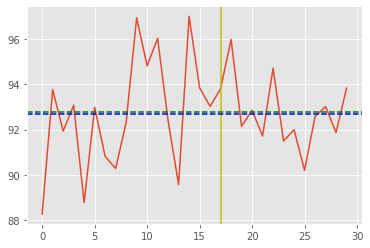

In [187]:
varPlot = varPowerFrequency.plot()
varPlot.axvline(x = crisisLine, color='y')
varPlot.axhline(y = varPowerFreqAfter.mean(), color='g', linestyle = '--')
varPlot.axhline(y = varPowerFreqBefore.mean(), color='b', linestyle = '--');

## Диаграммы ящиков с усами (boxplots) частот спектра до кризиса и после (16)

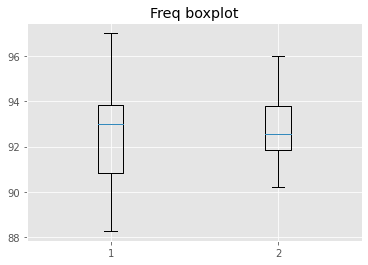

In [188]:
data = [varPowerFreqBefore, varPowerFreqAfter]
fig, ax = plt.subplots()
ax.set_title('Freq boxplot')
ax.boxplot(data);

После кризиса среднее значение мощности существенно уменьшается.

## График мощностей и частот с указанием в каких точках начался кризис (17)

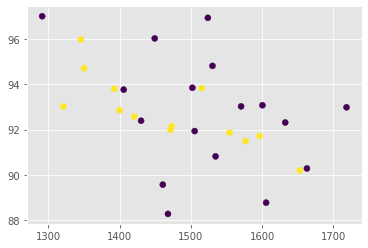

In [189]:
fig, ax = plt.subplots()
ax.scatter(varPower, varPowerFrequency, c=target['index'])

## Графики двух случайных частот (18)

[Int64Index([79, 40], dtype='int64')]


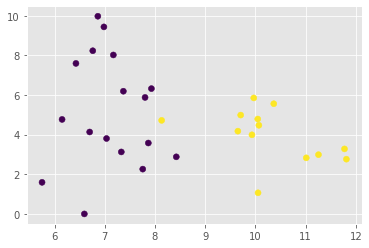

In [190]:
sample = varT.sample(2)
print([sample.index])

plt.scatter(sample.iloc[0,:], sample.iloc[1,:], c=target['index']);

## Метод понижения размерности (19)

In [191]:
pca = PCA(n_components=2)
pca.fit(varT)

PCA(n_components=2)

## Методы кластеризации (20)

In [192]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(varT)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [193]:
clustering = AgglomerativeClustering(n_clusters=2).fit(varT)
clustering.labels_

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [194]:
clustering = SpectralBiclustering(n_clusters=2, random_state=0).fit(varT)
print(clustering.row_labels_,end='\n\n')
print(clustering.column_labels_)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0]


# Ответы на контрольные вопросы
## 1.	Какие существуют алгоритмы кластерного анализа данных? Назовите не менее 3-ех и опишите их суть с математической точки зрения и расскажите чем они отличаются друг от друга.

## 2.	Какие метрики используются для оценки качества работы алгоритма кластеризации данных? Опишите данные метрики с математической точки зрения и скажите чем они отличаются друг от друга.
Для самих метрик качества обычно вводят следующую классификацию: Внутренние – к ним относятся метрики, которые при оценке качества используют какую-либо уже известную информацию о структуре кластеров, существующей в рассматриваемом множестве. Как правило, такие метрики применяются при оценке эффективности работы алгоритма кластеризации, когда в качестве тестового множества используется какое-либо множество данных с известной структурой классов.

Внешние – к ним относятся метрики, которые не имеют априори знаний о структуре классов и при оценке опираются только на ту информацию, которую можно получить, опираясь на множество данных. Для внешних метрик рассматриваются пары (xi ; xj ) из элементов X (кластеризуемое множество) и считаются количество пар которые по своей сути связаны с такими показателями как правильность точность и полнота.

Рассчитываются следующие пары:

* элементы принадлежат одному кластеру и одному классу: SS;
* элементы принадлежат одному кластеру, но разным классам: SD;
* элементы принадлежат разным кластерам, но одному классу: DS;
* элементы принадлежат разным классам и разным кластерам: DD.

Относительные – оценивают качество, сравнивая несколько кластерных структур между собой, не имея априорной информации и принимая в расчет только сведения о кластерной структуре и кластеризуемом множестве

## 3.	Каким способом можно повысить качество работы алгоритмов кластеризации?
Для повышения качества требуется соблюсти нормы оценки качества кластеризации. Для этого задачу можно переформулировать в терминах задачи дискретной оптимизации. Необходима так сопоставить объектам из множества X метки кластеров, чтобы значение выбранного функционала качества приняло наилучшее значение. В качестве примера, стремятся достичь минимума среднего внутрикластерного расстояния $$F_0=\frac{\sum_{i<j}[y_i=y_j]*\rho(x_i,x_j)}{\sum_{i<j}[y_i=y_j]}$$ или максимума среднего межкластерного расстояния $$F_1=\frac{\sum_{i<j}[y_i\not=y_j]*\rho(x_i,x_j)}{\sum_{i<j}[y_i\not=y_j]}$$.